# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimisation

## Downloading data

In addition to price data, constructing a market prior requires market-caps. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [3]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2020-04-22,2363.489990,21.799999,309.420013,100.989998,383.750000,45.680000,186.479996,173.520004,5.23,77.449997
2020-04-23,2399.449951,21.870001,305.399994,101.000000,369.640015,45.070000,182.039993,171.419998,5.46,75.150002
2020-04-24,2410.219971,22.180000,310.549988,101.190002,367.290009,45.430000,184.020004,174.550003,5.85,75.580002
2020-04-27,2376.000000,23.469999,308.779999,106.059998,362.029999,46.779999,185.889999,174.050003,7.20,77.739998
2020-04-28,2314.080078,23.889999,304.950012,106.209999,356.010010,46.740002,185.929993,169.809998,7.34,78.690002


In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    26.299288
1993-02-01    26.486324
1993-02-02    26.542448
1993-02-03    26.822998
1993-02-04    26.935240
Name: Adj Close, dtype: float64

In [5]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 1291583356928,
 'AMZN': 1153626800128,
 'NAT': 1080675584,
 'BAC': 207257452544,
 'DPZ': 13926364160,
 'DIS': 191755780096,
 'KO': 200743157760,
 'MCD': 138241736704,
 'COST': 134659825664,
 'SBUX': 92358451200}

## Constructing the prior

In [6]:
import pypfopt
pypfopt.__version__

'1.2.1'

In [7]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.3973137353940537

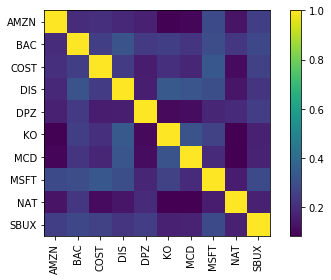

In [8]:
plotting.plot_covariance(S);

In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.169365
BAC     0.096674
COST    0.070544
DIS     0.088588
DPZ     0.044979
KO      0.060703
MCD     0.065044
MSFT    0.119617
NAT     0.048718
SBUX    0.074343
dtype: float64

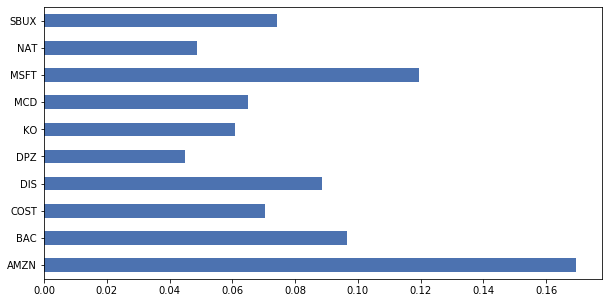

In [10]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

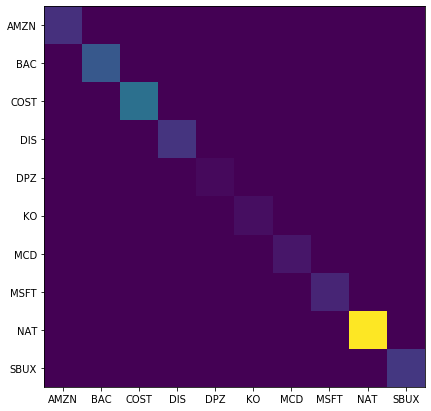

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.00459765, 0.00900048, 0.01219535, 0.00496581, 0.00079887,
       0.00125555, 0.0019799 , 0.00343636, 0.03291531, 0.00537145])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estiamte of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_averison="delta",
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.112862
BAC     0.145401
COST    0.052306
DIS     0.066776
DPZ     0.099675
KO      0.002370
MCD     0.106505
MSFT    0.094617
NAT     0.061092
SBUX    0.075309
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.169365,0.112862,0.10
BAC,0.096674,0.145401,0.30
COST,0.070544,0.052306,0.05
DIS,0.088588,0.066776,0.05
DPZ,0.044979,0.099675,0.20
KO,0.060703,0.002370,-0.05
MCD,0.065044,0.106505,0.15
MSFT,0.119617,0.094617,0.10
NAT,0.048718,0.061092,0.50
SBUX,0.074343,0.075309,0.10


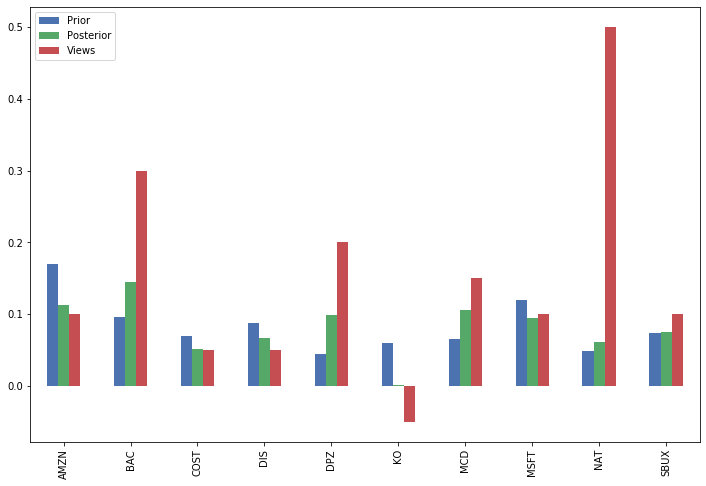

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is always between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

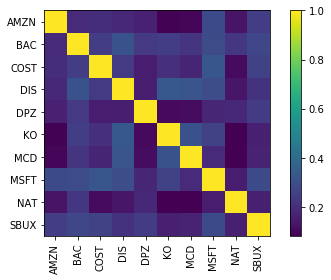

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:183: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


{'AMZN': 0.14371,
 'BAC': 0.20049,
 'COST': 0.04432,
 'DIS': 0.06266,
 'DPZ': 0.14042,
 'KO': 0.0,
 'MCD': 0.14217,
 'MSFT': 0.11942,
 'NAT': 0.06311,
 'SBUX': 0.0837}

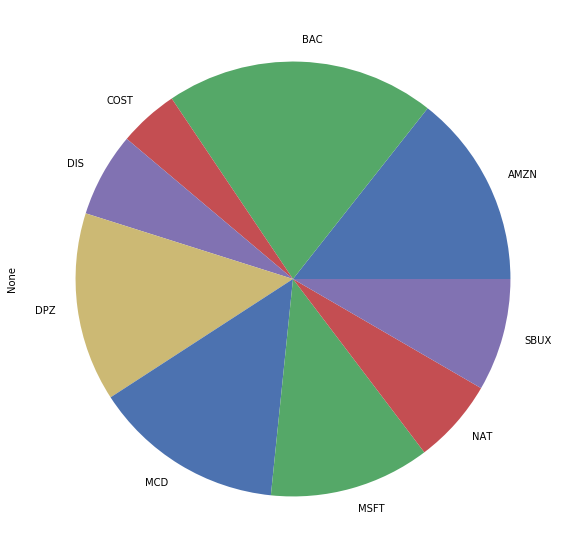

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $45.86


{'AMZN': 1.0,
 'BAC': 168.0,
 'COST': 3.0,
 'DIS': 12.0,
 'DPZ': 8.0,
 'MCD': 16.0,
 'MSFT': 15.0,
 'NAT': 182.0,
 'SBUX': 22.0}